## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [50]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Test undistortion on an image
img = mpimg.imread('../camera_cal/calibration10.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

## Now I can undistort and unwarp the images

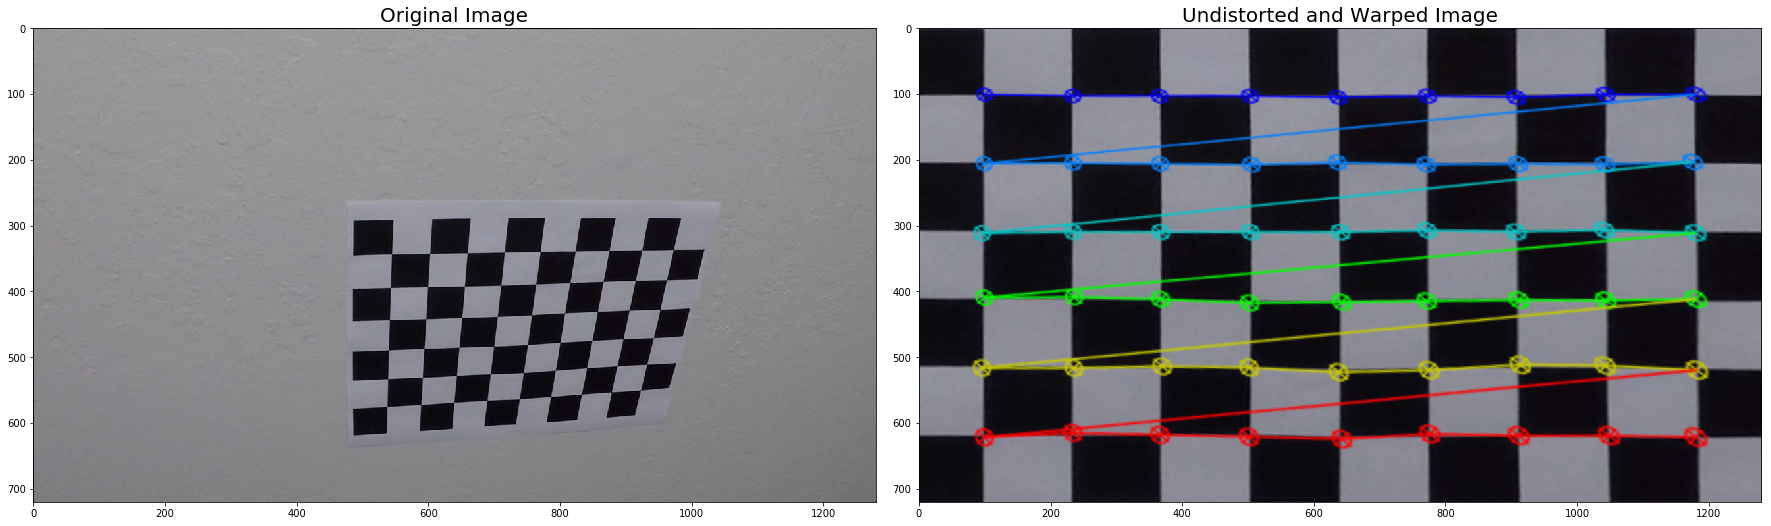

In [51]:
def corners_unwarp(img, nx, ny, mtx, dist, img_size):
    offset = 100
    undis = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undis, cv2.COLOR_BGR2GRAY)
    ret, corner = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        cv2.drawChessboardCorners(undis, (nx, ny), corner, True)

    src = np.float32([corner[0], corner[nx-1], corner[-1], corner[-nx]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undis, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("../output_images/undistort_and_warped.jpg")

## Before processing the image,  undistort and crop.
crop so that the front bumper of the car doesn't interfer the lane line detection.

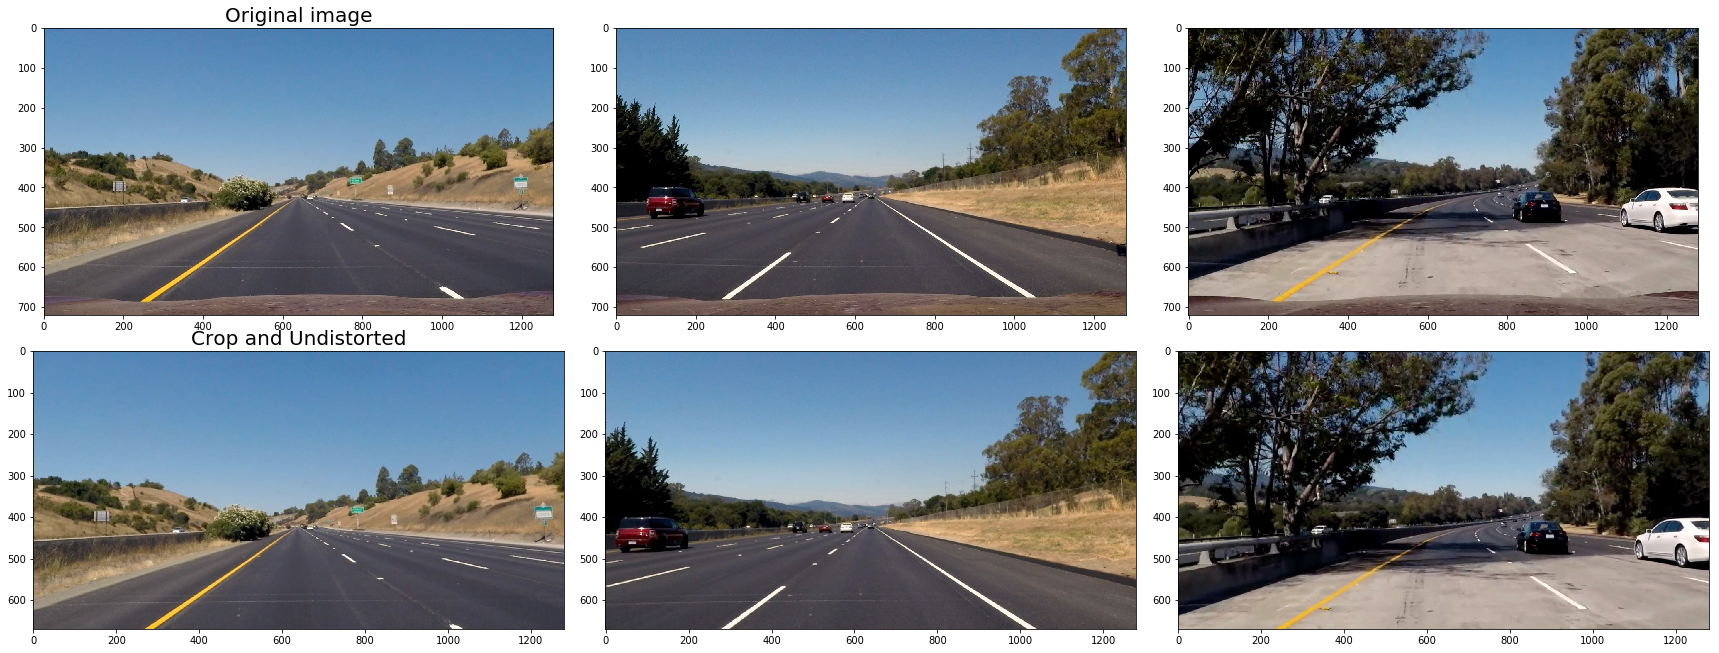

In [52]:
img = mpimg.imread('../test_images/straight_lines1.jpg') #RGB
img2 = mpimg.imread("../test_images/straight_lines2.jpg") #RGB
img3 = mpimg.imread("../test_images/test5.jpg") #RGB


undist = cv2.undistort(img, mtx, dist, None, mtx)
undist2 = cv2.undistort(img2, mtx, dist, None, mtx)
undist3 = cv2.undistort(img3, mtx, dist, None, mtx)


crop_undist = undist[:670,:]
crop_undist2 = undist2[:670,:]
crop_undist3 = undist3[:670,:]


f, ax = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
ax[0,0].imshow(img)
ax[0,0].set_title("Original image", fontsize=20)
ax[1,0].imshow(crop_undist)
ax[1,0].set_title("Crop and Undistorted", fontsize=20)
ax[0,1].imshow(img2)
ax[1,1].imshow(crop_undist2)
ax[0,2].imshow(img3)
ax[1,2].imshow(crop_undist3)
plt.savefig("../output_images/undistort_and_crop.png")


## Combine the image of derivative, Saturation, etc..
details are written in the writeup.

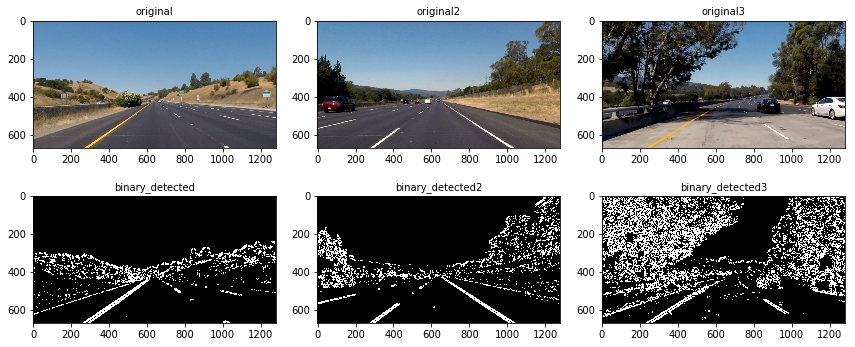

In [53]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), cvt="gray"):
    # Calculate directional gradient
    # Apply threshold
    if cvt == "gray":
        cvted_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif cvt == "s":
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        cvted_img = hls[:,:,2]
    elif cvt == "l":
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        cvted_img = hls[:,:,1]
    elif cvt == "h":
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        cvted_img = hls[:,:,0]
    elif cvt == "lshalf":
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        l_channel = hls[:,:,1]
        cvted_img = s_channel/2 + l_channel/2

    if orient == "x":
        sobel = cv2.Sobel(cvted_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(cvted_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = abs(sobel)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255), cvt="gray"):
    # Calculate gradient magnitude
    # Apply threshold
    if cvt == "gray":
        cvted_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif cvt == "lshalf":
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        l_channel = hls[:,:,1]
        cvted_img = s_channel/2 + l_channel/2

    sobelx = cv2.Sobel(cvted_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(cvted_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx, abs_sobely = abs(sobelx), abs(sobely)
    mag_sobel = ((abs_sobelx**2) + (abs_sobely**2))**(1/2)
    mag_sobel = np.uint8(255*mag_sobel / np.max(mag_sobel))
    mag_binary = np.zeros_like(mag_sobel)
    mag_binary[(mag_sobel >= mag_thresh[0]) & (mag_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2), cvt="gray"):
    # Calculate gradient direction
    # Apply threshold
    if cvt == "gray":
        cvted_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif cvt == "lshalf":
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        l_channel = hls[:,:,1]
        cvted_img = s_channel/2 + l_channel/2

    sobelx = abs(cv2.Sobel(cvted_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = abs(cv2.Sobel(cvted_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(dir)
    dir_binary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1

    return dir_binary

def hls_select(img, thresh=(170, 255), channel="s"):
    """
    1) Convert to HLS color space
    2) Apply a threshold to the S channel
    3) Return a binary image of threshold result
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel=="s":
        channel_ind = 2
    elif channel=="l":
        channel_ind = 1
    elif channel=="h":
        channel_ind = 0
    selected_channel = hls[:,:,channel_ind]
    binary_output = np.zeros_like(selected_channel)
    binary_output[(selected_channel > thresh[0]) & (selected_channel <= thresh[1])] = 1

    return binary_output


def binary_detection(crop_undist_img, ksize = 15):
    mag_lshalf = mag_thresh(crop_undist_img, sobel_kernel=ksize, mag_thresh=(20, 255), cvt="lshalf")
    dir_lshalf = dir_threshold(crop_undist_img, sobel_kernel=ksize, thresh=(0.7, 1.3), cvt="lshalf")
    gradx_s = abs_sobel_thresh(crop_undist_img, orient='x', sobel_kernel=ksize, thresh=(20, 255), cvt="s")
    gradx_l = abs_sobel_thresh(crop_undist_img, orient='x', sobel_kernel=ksize, thresh=(20, 255), cvt="l")
    grady_s = abs_sobel_thresh(crop_undist_img, orient='y', sobel_kernel=ksize, thresh=(20, 255), cvt="s")
    grady_l = abs_sobel_thresh(crop_undist_img, orient='y', sobel_kernel=ksize, thresh=(20, 255), cvt="l")

    magdir_combined = np.zeros_like(mag_lshalf)
    magdir_combined[ (mag_lshalf==1) & (dir_lshalf==1) ] = 1
    grad_combined = np.zeros_like(gradx_l)
    grad_combined[ (gradx_l==1) & (grady_l==1) | (gradx_s==1) & (grady_s==1) ] = 1

    all_combined = np.zeros_like(gradx_l)
    all_combined[ (magdir_combined==1) | (grad_combined==1) ] = 1

    #cv2.imwrite("../test_images/detected_test{}.jpg".format(i+1), all_combined*255)
    
    return all_combined


binary_detected = binary_detection(crop_undist, ksize = 15)
binary_detected2 = binary_detection(crop_undist2, ksize = 15)
binary_detected3 = binary_detection(crop_undist3, ksize = 15)


f, ax = plt.subplots(2, 3, figsize=(12,5))
f.tight_layout()
ax[0,0].imshow(crop_undist)
ax[0,0].set_title("original", fontsize=10)
ax[1,0].imshow(binary_detected, cmap="gray")
ax[1,0].set_title("binary_detected", fontsize=10)
ax[0,1].imshow(crop_undist2)
ax[0,1].set_title("original2", fontsize=10)
ax[1,1].imshow(binary_detected2, cmap="gray")
ax[1,1].set_title("binary_detected2", fontsize=10)
ax[0,2].imshow(crop_undist3)
ax[0,2].set_title("original3", fontsize=10)
ax[1,2].imshow(binary_detected3, cmap="gray")
ax[1,2].set_title("binary_detected3", fontsize=10)
plt.show()
plt.savefig("../output_images/binary_lanedetect.png")



## Transform to bird's eye view

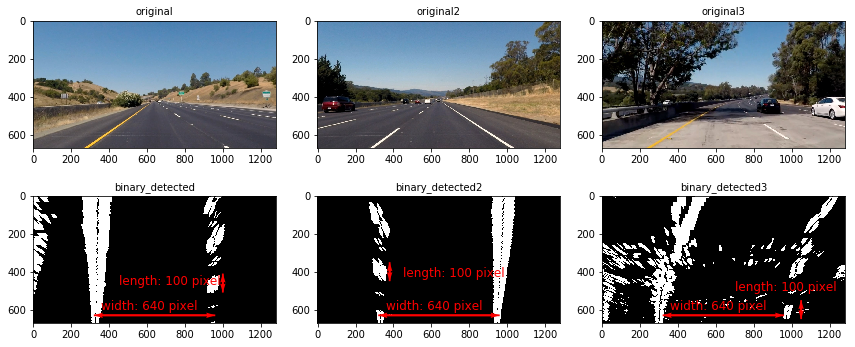

In [65]:
src = np.float32([ [593, 450], [685, 450], [1045, 670], [270, 670] ])
dst = np.float32([ [320, 0], [960, 0], [960, 670], [320, 670] ])

def perspective_transform(img, src, dst):
    """
    Apply bird's eye view transform to an image.
    """
    img_size = (img.shape[1], img.shape[0]) #(x, y)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

def perspective_untransform(img, src, dst):
    """
    Apply bird's eye view transform to an image.
    """
    img_size = (img.shape[1], img.shape[0]) #(x, y)
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)

    return unwarped


warped = perspective_transform(binary_detected, src, dst)
warped2 = perspective_transform(binary_detected2, src, dst)
warped3 = perspective_transform(binary_detected3, src, dst)



f, ax = plt.subplots(2, 3, figsize=(12,5))
f.tight_layout()
ax[0,0].imshow(crop_undist)
ax[0,0].set_title("original", fontsize=10)
ax[1,0].imshow(warped, cmap="gray")
ax[1,0].set_title("binary_detected", fontsize=10)
ax[1,0].quiver(320,630,640,0,scale=1280, color='r')
ax[1,0].quiver(960,630,-640,0,scale=1280, color='r')
ax[1,0].quiver(1000,410,0,-100,scale=1280, color='r')
ax[1,0].quiver(1000,510,0,100,scale=1280, color='r')
ax[1,0].text(360, 600, "width: 640 pixel", fontsize=12, color="r")
ax[1,0].text(450, 470, "length: 100 pixel", fontsize=12, color="r")
ax[0,1].imshow(crop_undist2)
ax[0,1].set_title("original2", fontsize=10)
ax[1,1].imshow(warped2, cmap="gray")
ax[1,1].set_title("binary_detected2", fontsize=10)
ax[1,1].quiver(320,630,640,0,scale=1280, color='r')
ax[1,1].quiver(960,630,-640,0,scale=1280, color='r')
ax[1,1].quiver(380,350,0,-100,scale=1280, color='r')
ax[1,1].quiver(380,450,0,100,scale=1280, color='r')
ax[1,1].text(360, 600, "width: 640 pixel", fontsize=12, color="r")
ax[1,1].text(450, 430, "length: 100 pixel", fontsize=12, color="r")
ax[0,2].imshow(crop_undist3)
ax[0,2].set_title("original3", fontsize=10)
ax[1,2].imshow(warped3, cmap="gray")
ax[1,2].set_title("binary_detected3", fontsize=10)
ax[1,2].quiver(320,630,640,0,scale=1280, color='r')
ax[1,2].quiver(960,630,-640,0,scale=1280, color='r')
ax[1,2].quiver(1050,550,0,-100,scale=1280, color='r')
ax[1,2].quiver(1050,650,0,100,scale=1280, color='r')
ax[1,2].text(360, 600, "width: 640 pixel", fontsize=12, color="r")
ax[1,2].text(700, 500, "length: 100 pixel", fontsize=12, color="r")
plt.show()
plt.savefig("../output_images/birds_eye_view.png")



## Now I can define the pixel/meter on x and y direaction.
Since the lane width and lane length after bird's eye view transform is roughly 640 pixel and 100 pixel, conversion rate of x, y axis are  3.7/100 meter/pixel, 3.0/640 meter/pixel.
## First, sliding window using convolution is applied to fit polynomial.

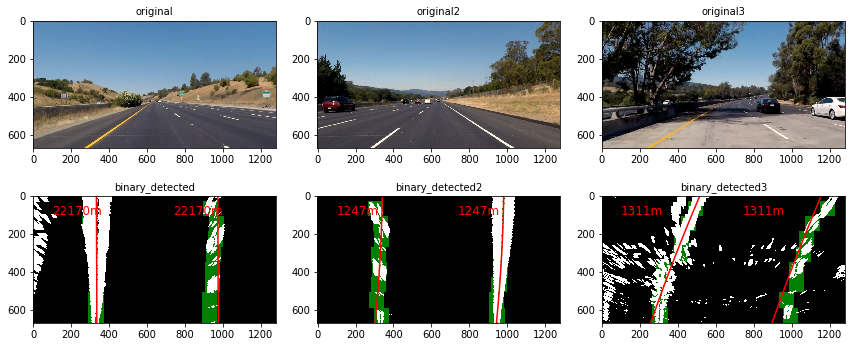

In [55]:
def fit_polynomial(img, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty, left_fit, right_fit

#function for drawing the mask
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin, minpix):
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    offset = window_width/2
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):, 100:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-offset + 100
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):1100], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-offset+int(image.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1, image.shape[0]//window_height):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window

        l_min_index = int(max(l_center+offset-margin,0)) #left lineの左側のidex 0を下回らないようにmax
        l_max_index = int(min(l_center+offset+margin,image.shape[1])) #image.shape[1]を上回らないようにmin
        #前のlineの左右の端(l_min_index〜l_max_index)の間で次の真ん中を探す
        l_center_next = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset #indexを返す
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center_next = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset

        #########for appending x,y index in the detedted lines###########
        win_y_low = int(image.shape[0]-(level+1)*window_height)
        win_y_high = int(image.shape[0]-level*window_height)
        win_xleft_low = int(max(l_center_next+offset-margin,0))
        win_xleft_high = int(min(l_center_next+offset+margin,image.shape[1]))
        win_xright_low = int(max(r_center_next+offset-margin,0))
        win_xright_high = int(min(r_center_next+offset+margin,image.shape[1]))

        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high) &
                          (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox <= win_xright_high) &
                           (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]

        #################################################################

        ### If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            l_center = l_center_next.copy()
        else:
            win_xleft_low = int(max(l_center+offset-margin,0))
            win_xleft_high = int(min(l_center+offset+margin,image.shape[1]))
            good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high) &
                              (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
            
        if len(good_right_inds) > minpix:
            r_center = r_center_next.copy()
        else:
            win_xright_low = int(max(r_center+offset-margin,0))
            win_xright_high = int(min(r_center+offset+margin,image.shape[1]))
            good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox <= win_xright_high) &
                               (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]

            
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, window_centroids


def measure_curvature_real(ploty, leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**(3/2) / abs(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**(3/2) / abs(2*right_fit_cr[0])

    return left_curverad, right_curverad

# if negative, car is shifted left.
def measure_offset(img, left_fitx, right_fitx):
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    lane_center = right_fitx[-1] - left_fitx[-1]
    img_center = img.shape[1]/2
    
    return (lane_center - img_center)*xm_per_pix
    



def my_lanefit(binary_warped, window_width, window_height, margin, minpix):
    leftx, lefty, rightx, righty, window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin, minpix)
    left_fitx, right_fitx, ploty, leftfit_co, rightfit_co = fit_polynomial(binary_warped, leftx, lefty, rightx, righty)
    left_curverad, right_curverad = measure_curvature_real(ploty, leftx, lefty, rightx, righty)
    center_offset = measure_offset(binary_warped, left_fitx, right_fitx)
    #sanity check both curvature within +- 10%
    if (left_curverad < right_curverad*0.9) or (left_curverad > right_curverad*1.1):
        if len(leftx) <= len(rightx):
            left_fitx = right_fitx.copy() - 640
            left_curverad = right_curverad.copy()
        else:
            right_fitx = left_fitx.copy() + 640
            right_curverad = left_curverad.copy()
    #sanity check lane width within +- 10% of 640 pixel
    elif (abs(leftfit_co[2] - rightfit_co[2]) < 640*0.9) or (abs(leftfit_co[2] - rightfit_co[2]) > 640*1.1):
        if len(leftx) <= len(rightx):
            left_fitx = right_fitx.copy() - 640
            left_curverad = right_curverad.copy()
        else:
            right_fitx = left_fitx.copy() + 640
            right_curverad = left_curverad.copy()

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        # Go through each level and draw the windows
        for level in range(0, len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found
            l_points[ (l_points == 255) | (l_mask == 1) ] = 255
            r_points[ (r_points == 255) | (r_mask == 1) ] = 255


        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results


    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)),np.uint8)

    

    return output, left_fitx, right_fitx, ploty, left_curverad, right_curverad, leftfit_co, rightfit_co, center_offset
    
# window settings
window_width = 80
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
minpix = 50

output, left_fitx, right_fitx, ploty, left_curverad, right_curverad, leftfit_co, rightfit_co, center_offset = my_lanefit(warped, window_width, window_height, margin, minpix)
output2, left_fitx2, right_fitx2, ploty2, left_curverad2, right_curverad2, leftfit_co2, rightfit_co2, center_offset2 = my_lanefit(warped2, window_width, window_height, margin, minpix)
output3, left_fitx3, right_fitx3, ploty3, left_curverad3, right_curverad3, leftfit_co3, rightfit_co3, center_offset3 = my_lanefit(warped3, window_width, window_height, margin, minpix)

f, ax = plt.subplots(2, 3, figsize=(12,5))
f.tight_layout()
ax[0,0].imshow(crop_undist)
ax[0,0].set_title("original", fontsize=10)
ax[1,0].imshow(output, cmap="gray")
ax[1,0].set_title("binary_detected", fontsize=10)
ax[1,0].plot(left_fitx, ploty, color="r")
ax[1,0].plot(right_fitx, ploty, color="r")
ax[1,0].text(100, 100, "{}m".format(str(int(left_curverad))), fontsize=12, color="r")
ax[1,0].text(740, 100, "{}m".format(str(int(right_curverad))), fontsize=12, color="r")

ax[0,1].imshow(crop_undist2)
ax[0,1].set_title("original2", fontsize=10)
ax[1,1].imshow(output2, cmap="gray")
ax[1,1].set_title("binary_detected2", fontsize=10)
ax[1,1].plot(left_fitx2, ploty3, color="r")
ax[1,1].plot(right_fitx2, ploty3, color="r")
ax[1,1].text(100, 100, "{}m".format(str(int(left_curverad2))), fontsize=12, color="r")
ax[1,1].text(740, 100, "{}m".format(str(int(right_curverad2))), fontsize=12, color="r")

ax[0,2].imshow(crop_undist3)
ax[0,2].set_title("original3", fontsize=10)
ax[1,2].imshow(output3, cmap="gray")
ax[1,2].set_title("binary_detected3", fontsize=10)
ax[1,2].plot(left_fitx3, ploty3, color="r")
ax[1,2].plot(right_fitx3, ploty3, color="r")
ax[1,2].text(100, 100, "{}m".format(str(int(left_curverad3))), fontsize=12, color="r")
ax[1,2].text(740, 100, "{}m".format(str(int(right_curverad3))), fontsize=12, color="r")

plt.show()
plt.savefig("../output_images/sliding_window_and_curvature.png")



## Now, it's time to project my measurement back down onto the road.

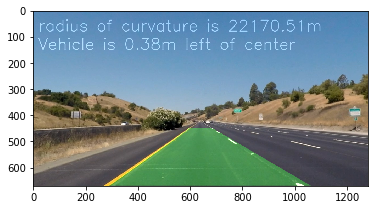

In [56]:
def unwarp(warped, left_fitx, right_fitx, ploty, left_curverad, right_curverad, center_offset):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_untransform(color_warp, src, dst)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(newwarp, "radius of curvature is {}m".format(round(left_curverad, 2)),(20,80), font, 2,(255,255,255),2,cv2.LINE_AA)
    if center_offset >= 0:
        cv2.putText(newwarp, "Vehicle is {}m right of center".format(round(abs(center_offset), 2)),(20,150), font, 2,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(newwarp, "Vehicle is {}m left of center".format(round(abs(center_offset), 2)),(20,150), font, 2,(255,255,255),2,cv2.LINE_AA)



    return newwarp

newwarp = unwarp(warped, left_fitx, right_fitx, ploty, left_curverad, right_curverad, center_offset)
plt.imshow(newwarp)
# Combine the result with the original image
result = cv2.addWeighted(crop_undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.savefig("../output_images/unwarp.png")



# Moving on to video!!

In [57]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [75]:
class Line():
    def __init__(self):
        self.first = True
        # was the line detected in the last iteration?
        self.detected = True  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [0,0,0]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

left = Line()
right = Line()

a_thresh = 1.8
b_thresh = 1.5
c_thresh = 1.0

def process_image(image):
    ###undistort and crop###
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    crop_undist = undist[:670,:]
    
    ###bilinear transform###
    binary_detected = binary_detection(crop_undist, ksize = 15)
    
    ###perspective transform###
    warped = perspective_transform(binary_detected, src, dst)
    
    ###sliding window###
    output, left_fitx, right_fitx, ploty, left_curverad, right_curverad, leftfit_co, rightfit_co, center_offset = my_lanefit(warped, window_width, window_height, margin, minpix)    
    
    left.diffs = abs(leftfit_co - left.current_fit)
    right.diffs = abs(rightfit_co - right.current_fit)
    
    #run this in first image
    if left.first or right.first:
        left.recent_xfitted.append(left_fitx)
        left.current_fit = leftfit_co
        left.radius_of_curvature = left_curverad
        ave_left_fitx = np.average(left.recent_xfitted[-10:], axis=0)
        left.bestx = ave_left_fitx
        
        right.recent_xfitted.append(right_fitx)
        right.current_fit = rightfit_co
        right.radius_of_curvature = right_curverad
        ave_right_fitx = np.average(right.recent_xfitted[-10:], axis=0)
        right.bestx = ave_right_fitx 
        
        left.line_base_pos = center_offset
        
        newwarp = unwarp(warped, left_fitx, right_fitx, ploty, left_curverad, right_curverad, center_offset)
        result = cv2.addWeighted(crop_undist, 1, newwarp, 0.3, 0)
        
        left.first = False
        right.first = False
        
        return result
    
    if np.average(abs(left_fitx-left.bestx)) > 100:#if the difference is more than 100pixel
        left.detected = False
    elif left.diffs[0]/leftfit_co[0] > a_thresh or left.diffs[1]/leftfit_co[1] > b_thresh or left.diffs[2]/leftfit_co[2] > c_thresh:
        left.detected = False
    else:
        left.detected = True

    if np.average(abs(right_fitx-right.bestx)) > 100:#if the difference is more than 100pixel
        right.detected = False
    elif right.diffs[0]/rightfit_co[0] > a_thresh or right.diffs[1]/rightfit_co[1] > b_thresh or right.diffs[2]/rightfit_co[2] > c_thresh:
        right.detected = False
    else:
        right.detected = True
        
        
    if left.detected:
        left.recent_xfitted.append(left_fitx)
        left.current_fit = leftfit_co
        left.radius_of_curvature = left_curverad
        ave_left_fitx = np.average(left.recent_xfitted[-10:], axis=0)
        left.bestx = ave_left_fitx
        left.line_base_pos = center_offset
        
    if right.detected:
        right.recent_xfitted.append(right_fitx)
        right.current_fit = rightfit_co
        right.radius_of_curvature = right_curverad
        ave_right_fitx = np.average(right.recent_xfitted[-10:], axis=0)
        right.bestx = ave_right_fitx 
        left.line_base_pos = center_offset

    
    
    ###unwarp and combine with original img###
    newwarp = unwarp(warped, left.bestx, right.bestx, ploty, left.radius_of_curvature, right.radius_of_curvature, left.line_base_pos)
    result = cv2.addWeighted(crop_undist, 1, newwarp, 0.3, 0)
    
    
    
    return result
    

In [76]:
output_path = '../test_videos_output/challenge_video_myoutput.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("../challenge_video.mp4")#.subclip(19, 25)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video ../test_videos_output/challenge_video_myoutput.mp4
[MoviePy] Writing video ../test_videos_output/challenge_video_myoutput.mp4


100%|█████████▉| 484/485 [05:08<00:00,  1.59it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/moviepy/video/io/ffmpeg_reader.py:132: UserWarning: Warning: in file ../challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)

100%|██████████| 485/485 [05:08<00:00,  1.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/challenge_video_myoutput.mp4 

CPU times: user 4min 15s, sys: 9.42 s, total: 4min 24s
Wall time: 5min 11s


In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))